In [2]:
from os import environ
import numpy as np
import pylab as plt

In [3]:
%matplotlib inline

In [4]:
basedir = '{}//astro/papers/cs_review/figures/dlogP_dlogp'.format(environ['HOME'])

In [129]:
def read_Cell(path, ell_min, ell_max):
    """Read P_kappa file and return log_10(ell), log_10(C_ell) within ell-range
    """
    
    pk = np.loadtxt(path)
    ell  = pk[:,0]
    Cell = pk[:,1] / (ell * (ell+1) / (2 * np.pi))

    ran     = (ell>=ell_min) & (ell<=ell_max)
    
    return np.log10(ell[ran]), np.log10(Cell[ran])

In [130]:
ell_min = 10
ell_max = 1e4

## Standard power spectrum

In [131]:
logell, logCell = read_Cell('{}/P_kappa'.format(basedir), ell_min, ell_max)

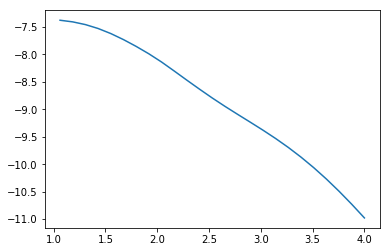

In [132]:
p = plt.plot(logell, logCell)

## Fitting functions

In [12]:
from scipy.optimize import curve_fit

In [96]:
def quadratic(x, *params):
    """Used to fit quadratic function varying all three parameters
    """
    (c, x0, a) = np.array(params)
    return c + a * (x - x0)**2

In [97]:
def quadratic_c(x, *params):
    """Used to fit quadratic function varying constant coefficient only
    """
    (c) = np.array(params)
    return c + a_glob * (x - x0_glob)**2

In [98]:
def quadratic_x0(x, *params):
    """Used to fit quadratic function varying shift parameter only
    """
    (x0) = np.array(params)
    return c_glob + a_glob * (x - x0)**2

## Fitting

### Fit standard power spectrum

In [135]:
p0 = [0, 0, 0]
popt, pcov = curve_fit(quadratic, logell, logCell + logell, p0)

In [136]:
popt

array([-6.11568527,  1.85132115, -0.17586216])

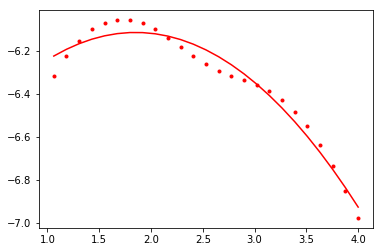

In [138]:
plt.plot(logell, logCell + logell, 'r.', logell, quadratic(logell, *popt), 'r-')

### Fit standard power spectrum with higher amplitude (small-scale normalization $\sigma_8$)

#### Fit by varying all coefficients

In [139]:
logell_ps, logCell_ps = read_Cell('{}/normalization+dp/P_kappa'.format(basedir), ell_min, ell_max)

In [142]:
p0 = [0, 0, 0]
popt_ps, pcov_ps = curve_fit(quadratic, logell_ps, logCell_ps + logell_ps, p0)

In [143]:
popt_ps

array([-6.01808291,  1.91649442, -0.18913766])

#### Fit by only varying amplitude

In [144]:
x0_glob, a_glob  = popt[1], popt[2]
p0  = [0]
popt_ps_A, pcov_ps_A = curve_fit(quadratic_c, logell_ps, logCell_ps + logell_ps, p0)

In [145]:
popt_ps_A

array([-6.0186158])

### Fit standard power spectrum with higher matter density $\Omega_{\rm m}$ (tilt and amplitude parameter)

#### Fit by varying all parameters

In [146]:
logell_pO, logCell_pO = read_Cell('{}/Omega_m+dp/P_kappa'.format(basedir), ell_min, ell_max)

In [147]:
p0 = [0, 0, 0]
popt_pO, pcov_pO = curve_fit(quadratic, logell_pO, logCell_pO + logell_pO, p0)

In [148]:
popt_pO

array([-6.07109413,  1.97521342, -0.19338417])

#### Fit by varying only shift parameter

In [154]:
c_glob, a_glob  = popt[0], popt[2]
p0  = [0]
popt_pO_x0, pcov_pO_x0 = curve_fit(quadratic_x0, logell_pO, logCell_pO + logell_pO, p0)

In [155]:
popt_pO_x0

array([1.97277022])

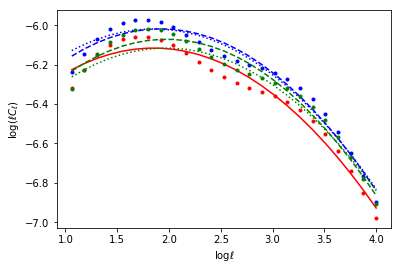

In [156]:
plt.plot( \
    logell, logCell + logell, 'r.', \
    logell, quadratic(logell, *popt), 'r-', \
    logell_ps, logCell_ps + logell, 'b.', \
    logell_ps, quadratic(logell_ps, *popt_ps), 'b--', \
    logell_ps, quadratic_c(logell_ps, *popt_ps_A), 'b:', \
    logell_pO, logCell_pO + logell, 'g.', \
    logell_pO, quadratic(logell_pO, *popt_pO), 'g--', \
    logell_pO, quadratic_x0(logell_pO, *popt_pO_x0), 'g:', \
)
plt.xlabel('$\log \ell$')
plt.ylabel('$\log(\ell C_\ell)$')